# **UNIVERSIDAD POLITÉCNICA SALESIANA**

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png" alt="logo universidad" width="550" height="150">

### **CIENCIAS DE LA COMPUTACIÓN**
### **INTELIGENCIA ARTIFICIAL**

---
### **PRÁCTICA INTERCICLO**
### **Optimización - Redes Neuronales**
---

**Integrantes:** Paúl Sebastián Naspud, Jennyfer Camila Ramírez

**Fecha de Entrega:** 02 de diciembre de 2025

---



### Model Configuration Summary

The following table summarizes the preprocessing strategies applied to each model. All models include dataset balancing, while the use of encoding, scaling, and PCA varies according to the theoretical and practical requirements of each approach.

| Model               | Transformations                  | Scaling (Standard / MinMax)  | PCA | Balancing | 
|---------------------|----------------------------------|------------------------------|-----|-----------|
| Neural Network      | Yes                              | Yes                          | Yes | Yes       |
| Neural Network      | Yes                              | Yes                          | No  | Yes       |
| KNN                 | Yes                              | Yes                          | Yes | Yes       |
| KNN                 | Yes                              | Yes                          | No  | Yes       |
| Clustering          | Yes                              | Yes                          | Yes | Yes       |
| Clustering          | Yes                              | Yes                          | No  | Yes       |
| Bayesian Network    | Yes                              | No                           | No  | Yes       |


## Índice
- [1. Carga del Data Set](#sec1)
- [2. Balanceo del Dataset](#sec2)
  - [2.1 Verificación](#sec21)
  - [2.2 Corrección con SMOTE](#sec22)
  - [2.3 Análisis del Data Set](#sec23)
- [3. Funciones de Carga y Generación de Variables](#sec3)
- [4. Modelado y Optimización](#sec4)
  - [4.1 RN Base](#sec41)
  - [4.2 RN optimizada parámetros de compilación](#sec42)
  - [4.3 RN optimizada parámetros de densidad de capas](#sec43)
  - [4.4 RN optimizada parámetros funciones de capas](#sec44)
  - [4.5 RN optimizada Dropout](#sec45)
- [5. Comparación de Modelos](#sec5)
- [6. Predicción con Nuevos Casos](#sec6)
- [7. Conclusiones](#sec7)


In [ ]:
# Bibliotecas a usar
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
import mlflow

from imblearn.over_sampling import SMOTE

## <span id="sec1"></span> **1. K-Neighbor Models**



### <span id="sec11"></span> **1.1 Data Upload**

In [ ]:
df = pd.read_csv("./_attachments/datasets/data-set-geometric-labels.csv", sep=',')
print("Dataset loaded successfully")
df.head()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GENERO_f               704 non-null    float64
 1   GENERO_m               704 non-null    float64
 2   ETNIA_?                704 non-null    float64
 3   ETNIA_Asian            704 non-null    float64
 4   ETNIA_Black            704 non-null    float64
 5   ETNIA_Hispanic         704 non-null    float64
 6   ETNIA_Latino           704 non-null    float64
 7   ETNIA_Middle Eastern   704 non-null    float64
 8   ETNIA_Others           704 non-null    float64
 9   ETNIA_Pasifika         704 non-null    float64
 10  ETNIA_South Asian      704 non-null    float64
 11  ETNIA_Turkish          704 non-null    float64
 12  ETNIA_White-European   704 non-null    float64
 13  ETNIA_others           704 non-null    float64
 14  EDAD                   704 non-null    float64
 15  RESULT

## <span id="sec2"></span> **2. Balanceo del Dataset**


### <span id="sec21"></span> **2.1 Verificación**

El análisis de la variable objetivo muestra un fuerte desbalance: el 73.15% de los registros pertenecen a la clase 0, mientras que solo el 26.85% corresponden a la clase 1. Esto indica que el modelo, si se entrena así, tenderá a favorecer la clase mayoritaria. Por ello, es necesario equilibrar el dataset antes del entrenamiento para evitar sesgos y mejorar el desempeño en ambas clases.

In [15]:
conteo = df['OBJETIVO_ASD'].value_counts()
porcentaje = df['OBJETIVO_ASD'].value_counts(normalize=True) * 100

print("Conteo por clase:")
print(conteo)
print("\nPorcentaje por clase:")
print(porcentaje)


Conteo por clase:
OBJETIVO_ASD
0    515
1    189
Name: count, dtype: int64

Porcentaje por clase:
OBJETIVO_ASD
0    73.153409
1    26.846591
Name: proportion, dtype: float64


### <span id="sec22"></span> **2.2 Corrección con SMOTE**

En lugar de duplicar datos, utilizaremos SMOTE (Synthetic Minority Over-sampling Technique), que genera ejemplos sintéticos para la clase minoritaria. Esto permite que la red neuronal entrene con datos más variados y realistas, mejorando su capacidad de generalización sin simplemente repetir registros existentes.




In [16]:
X = df.drop(columns=['OBJETIVO_ASD'])
y = df['OBJETIVO_ASD']

print("Shape original:", X.shape)
print("Distribución original:")
print(y.value_counts())

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Reconstruir DataFrame balanceado
df_bal = pd.DataFrame(X_bal, columns=X.columns)
df_bal['OBJETIVO_ASD'] = y_bal

print("\nShape balanceado:", df_bal.shape)
print("Distribución después de SMOTE:")
print(df_bal['OBJETIVO_ASD'].value_counts())


Shape original: (704, 29)
Distribución original:
OBJETIVO_ASD
0    515
1    189
Name: count, dtype: int64

Shape balanceado: (1030, 30)
Distribución después de SMOTE:
OBJETIVO_ASD
0    515
1    515
Name: count, dtype: int64


### <span id="sec23"></span> **2.3 Análisis del Data Set**


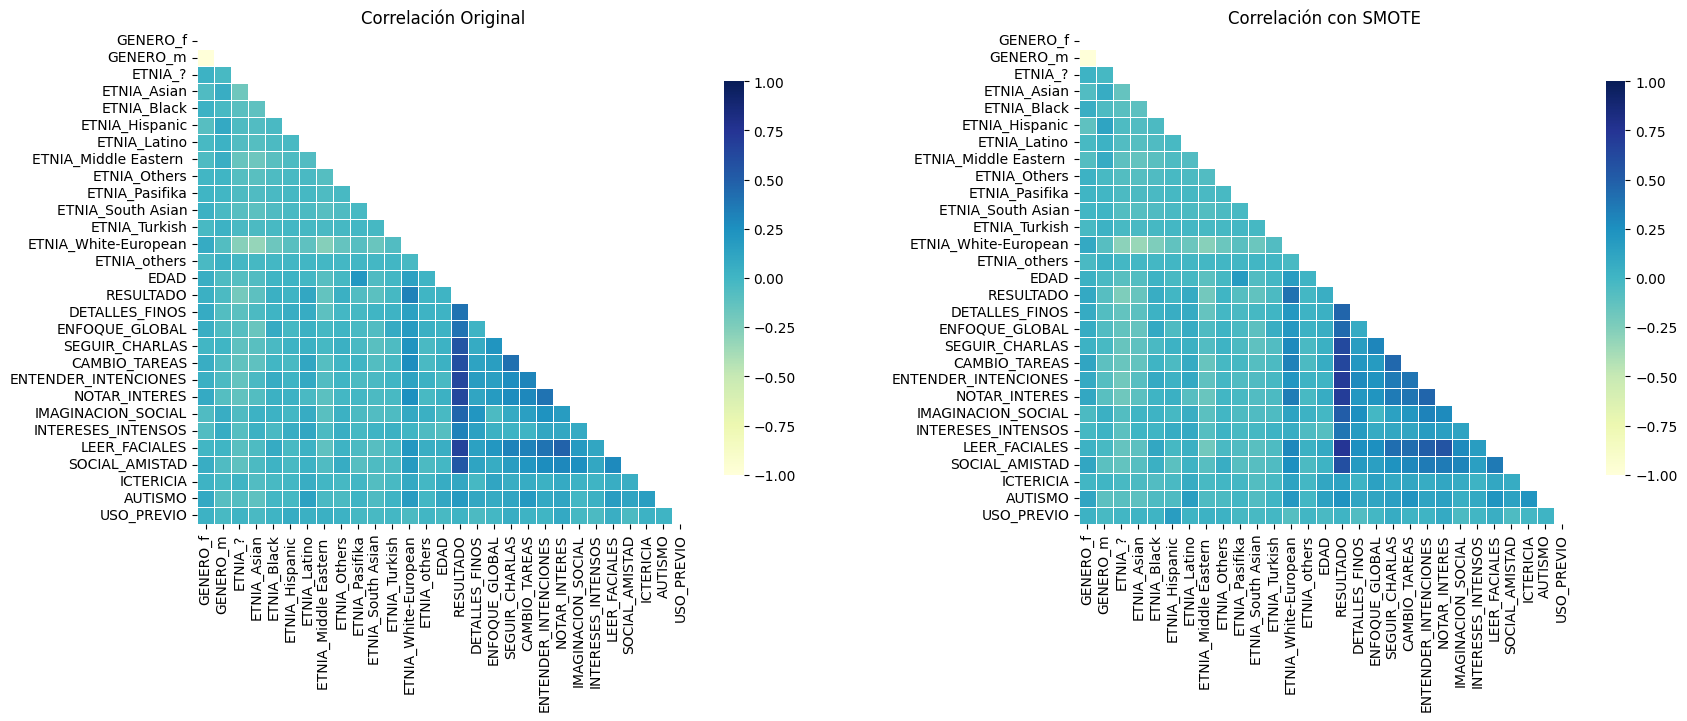

In [17]:
corr_original = df.drop(columns=['OBJETIVO_ASD']).corr()
corr_bal = df_bal.drop(columns=['OBJETIVO_ASD']).corr()

mask = np.zeros_like(corr_original, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(18, 7))

# --- Correlación ORIGINAL ---
plt.subplot(1, 2, 1)
sns.heatmap(
    corr_original,
    mask=mask,
    cmap='YlGnBu',
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    vmin=-1, vmax=1
)
plt.title("Correlación Original")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# --- Correlación con SMOTE ---
plt.subplot(1, 2, 2)
sns.heatmap(
    corr_bal,
    mask=mask,
    cmap='YlGnBu',
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    vmin=-1, vmax=1
)
plt.title("Correlación con SMOTE")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

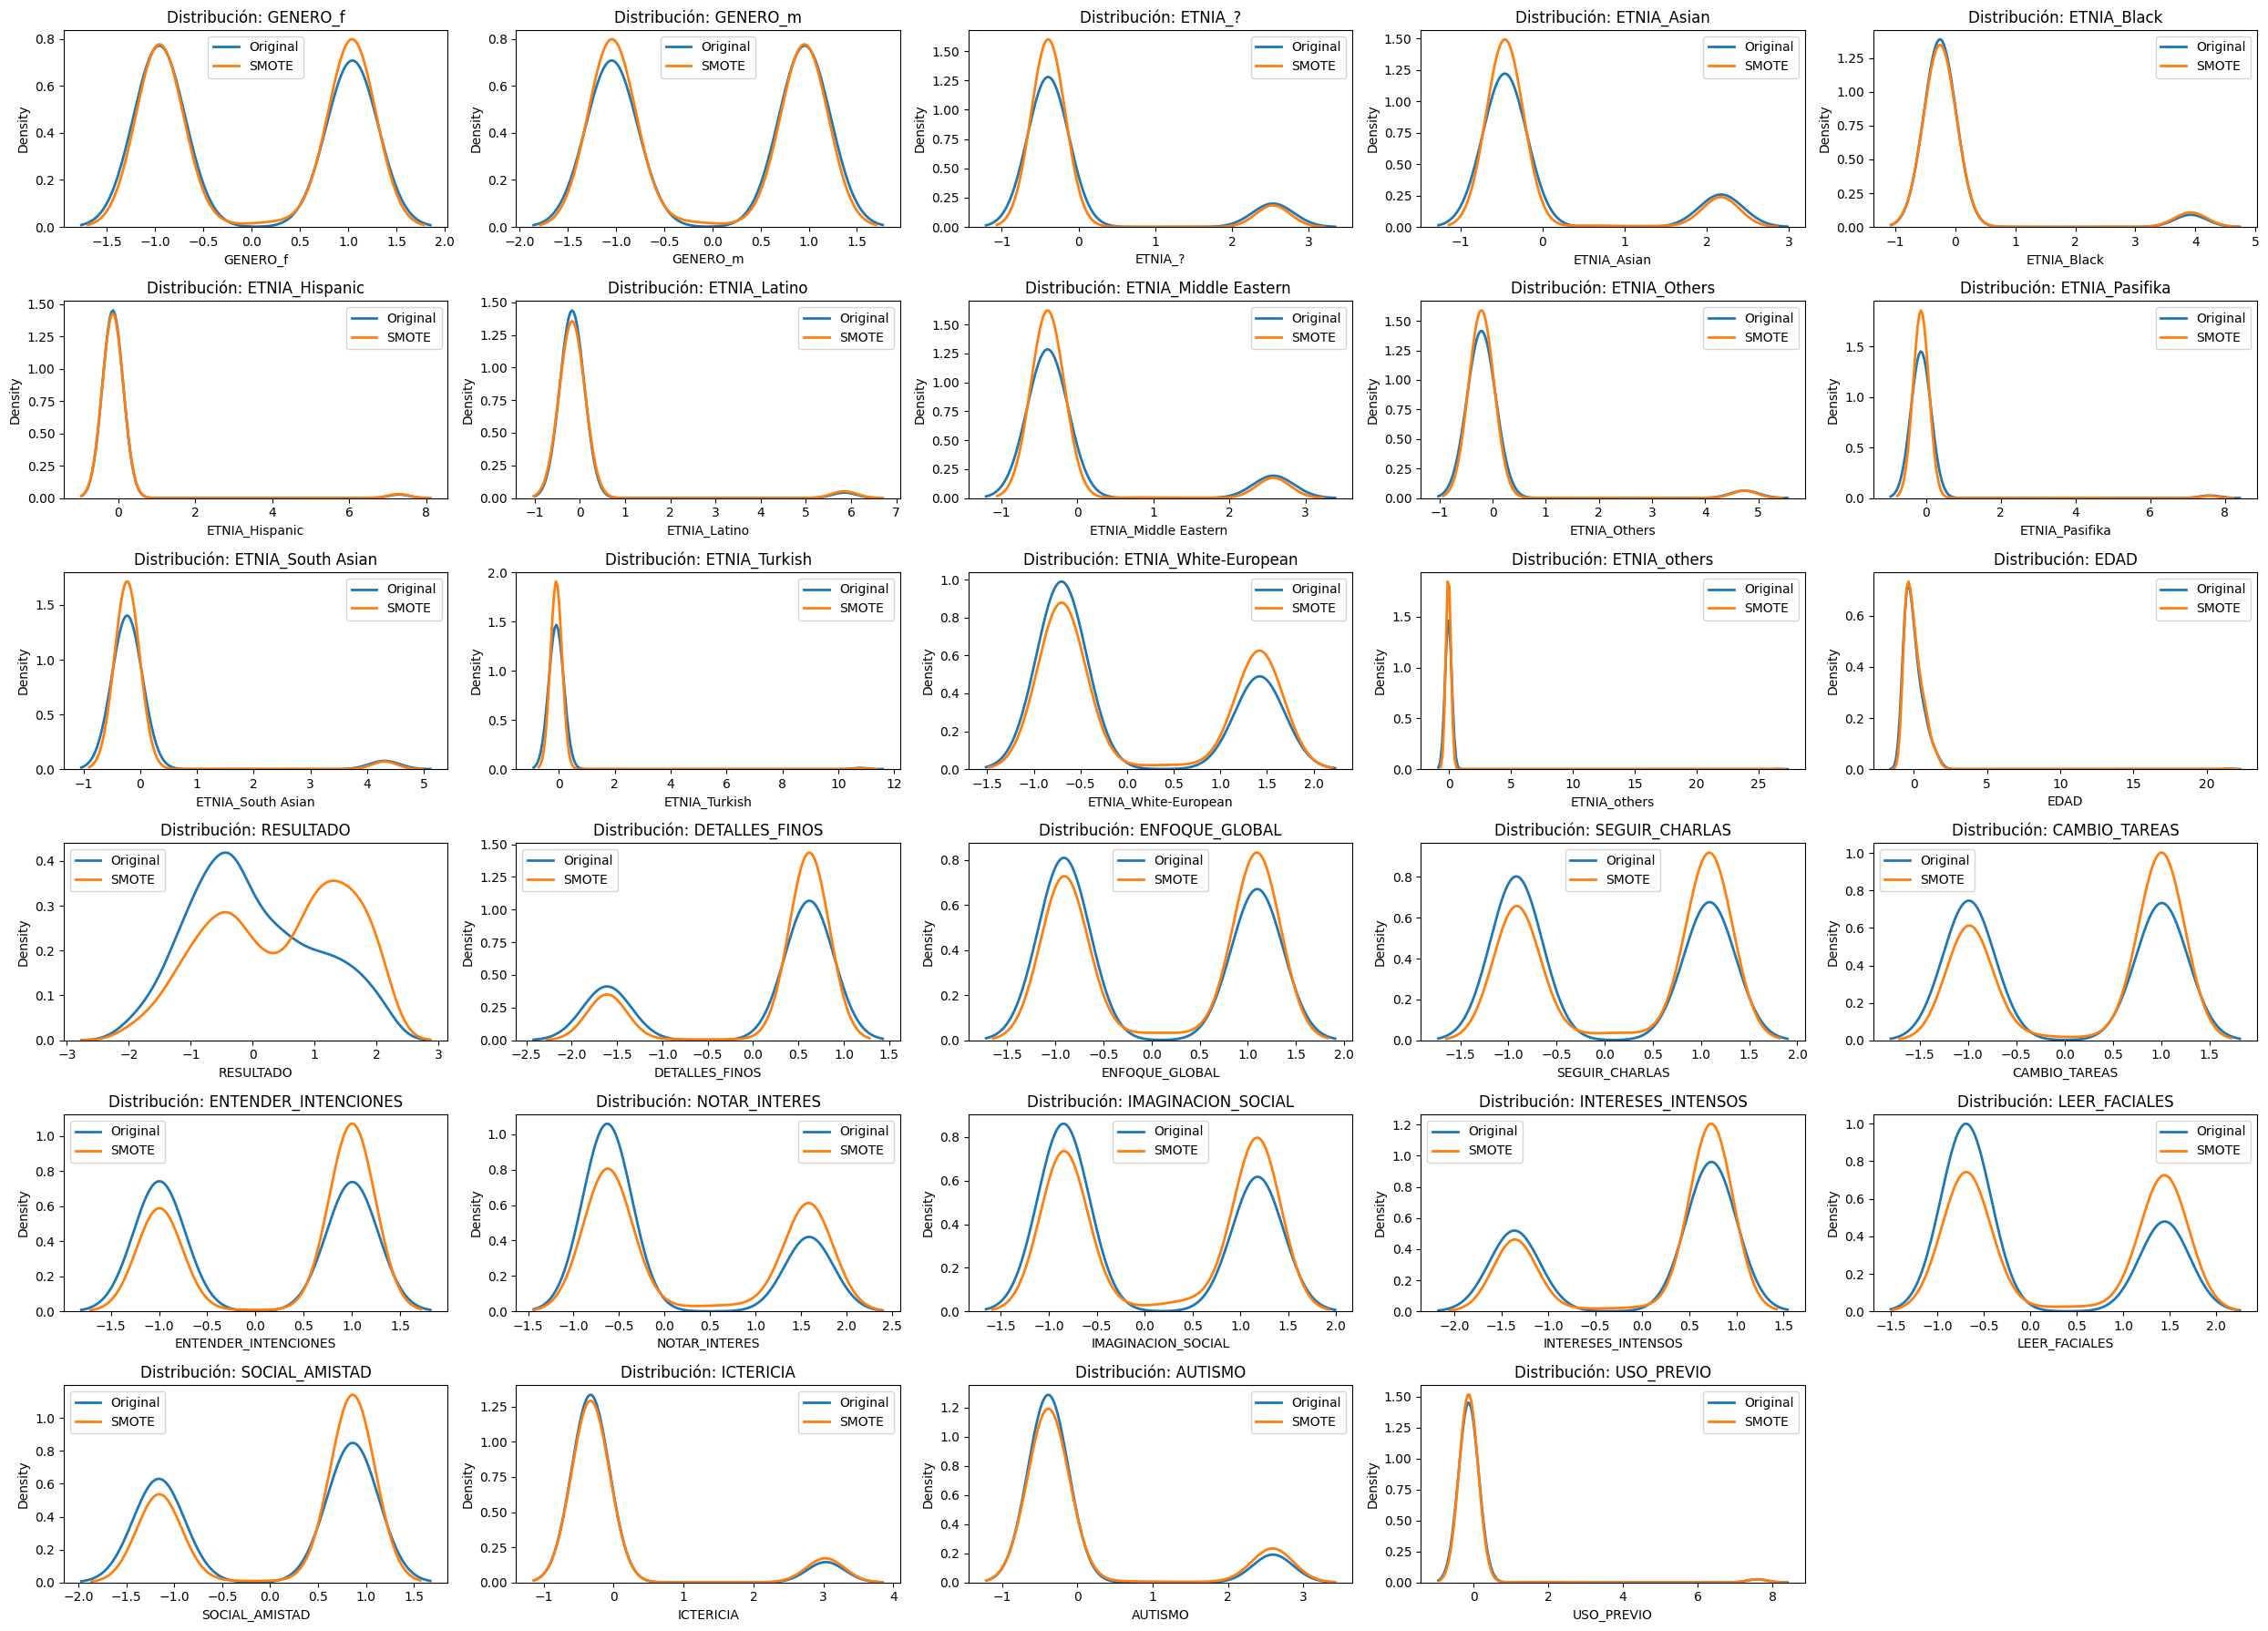

In [18]:
columnas = X.columns

n_vars = len(columnas)
n_cols = 5
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(columnas):
    ax = axes[i]
    sns.kdeplot(df[col], label="Original", lw=2, ax=ax)
    sns.kdeplot(df_bal[col], label="SMOTE", lw=2, ax=ax)
    ax.set_title(f"Distribución: {col}")
    ax.legend()
    ax.tick_params(axis='x', rotation=0)

# Ocultar ejes sobrantes si hay más subplots que columnas
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

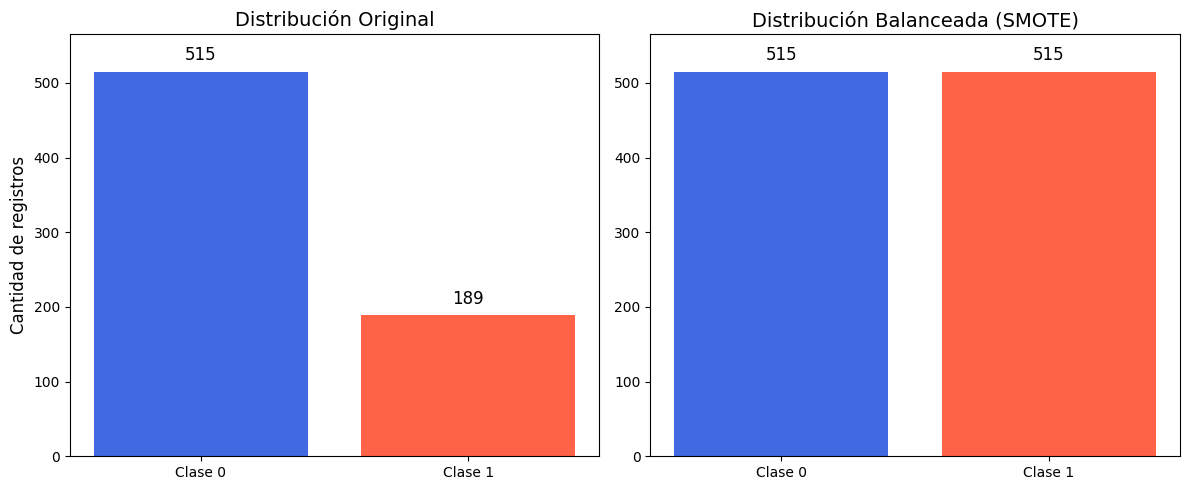

In [19]:
conteo_orig = df["OBJETIVO_ASD"].value_counts().sort_index()
conteo_bal  = df_bal["OBJETIVO_ASD"].value_counts().sort_index()

colors = ["royalblue", "tomato"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(["Clase 0", "Clase 1"],
            [conteo_orig.get(0, 0), conteo_orig.get(1, 0)],
            color=colors)

axes[0].set_title("Distribución Original", fontsize=14)
axes[0].set_ylabel("Cantidad de registros", fontsize=12)
axes[0].set_ylim([0, max(conteo_bal.values) + 50])

for i, v in enumerate([conteo_orig.get(0, 0), conteo_orig.get(1, 0)]):
    axes[0].text(i, v + 15, str(v), ha='center', fontsize=12)

axes[1].bar(["Clase 0", "Clase 1"],
            [conteo_bal.get(0, 0), conteo_bal.get(1, 0)],
            color=colors)

axes[1].set_title("Distribución Balanceada (SMOTE)", fontsize=14)
axes[1].set_ylim([0, max(conteo_bal.values) + 50])

for i, v in enumerate([conteo_bal.get(0, 0), conteo_bal.get(1, 0)]):
    axes[1].text(i, v + 15, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


## <span id="sec3"></span> **3. Funciones de Carga y Generación de Variables**


In [20]:
def guardarNN(model,nombreArchivo):
    print("Guardando Red Neuronal en Archivo")
    model.save(nombreArchivo+'.h5')
    print("Red Neuronal Grabada en Archivo")

def cargarNN(nombreArchivo):
    model = load_model(nombreArchivo+'.h5')
    print("Red Neuronal Cargada desde Archivo")
    return model

In [21]:
pipe = joblib.load("pipeline_transformacion.pkl")
set_config(display="diagram")
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('catnom',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['GENERO', 'ETNIA']),
                                                 ('num_bin', 'passthrough',
                                                  ['EDAD', 'RESULTADO',
                                                   'DETALLES_FINOS',
                                                   'ENFOQUE_GLOBAL',
                                                   'SEGUIR_CHARLAS',
                                                   'CAMBIO_TAREAS',
                                                   'ENTENDER_INTENCIONES',
                                                   'NOTAR_INTERES',
                                                   'IMAGINACION_SOCIAL',
                                                   'INTERESES_INTENSOS',
                                                   'LEER_FACIALES',
                                                   'SOCIAL_AMISTAD',
                                                   'ICTERICIA', 'AUTISMO',
                                                   'USO_PREVIO'])])),
                ('scaler', StandardScaler())])

## <span id="sec4"></span> **4. Modelado y Optimización**

| Modelo                | Capas ocultas | Neuronas por capa                | Funciones de activación            | Epochs | Batch size | Optimizador | Dropout                  |
|-----------------------|----------------|----------------------------------|------------------------------------|--------|------------|-------------|---------------------------|
| RN_BASE               | 1              | 4                                | Sigmoid                            | 10     | 16         | RMSProp     | No                        |
| RN_COMPILACION        | 1              | 4                                | Sigmoid                            | 35     | 4          | Adam        | No                        |
| RN_DENSIDAD           | 4              | 4 – 12 – 8 – 4                   | Sigmoid – Sigmoid – Sigmoid – Sigmoid | 35     | 16         | RMSProp     | No                        |
| RN_FUNCIONES_CAPA     | 3              | 4 – 4 – 4                        | Tanh – ReLU – Tanh                 | 35     | 16         | RMSProp     | No                        |
| RN_DROPOUT            | 3              | 8 – 4 – 4                        | Sigmoid – Sigmoid – Sigmoid        | 25     | 16         | RMSProp     | 0.25 – 0 – 0.25           |


In [22]:
resultados_modelos = []
resultados_metricas = []

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Optimizacion_Redes_Neuronales_Interciclo")

<Experiment: artifact_location='/home/paul/univerirsidad/septimo/IA/Practicas/Practica 4/mlruns/1', creation_time=1765684964461, experiment_id='1', last_update_time=1765684964461, lifecycle_stage='active', name='Optimizacion_Redes_Neuronales_Interciclo', tags={}>

In [23]:
#df_bal = df
X = df_bal.drop(columns=['OBJETIVO_ASD'])
y = df_bal['OBJETIVO_ASD']

from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train:", XTrain.shape, yTrain.shape)
print("Test :", XTest.shape, yTest.shape)


Train: (824, 29) (824,)
Test : (206, 29) (206,)


In [24]:
def crear_red_general(
    nombre_modelo: str,
    capas: list = None,
    epochs: int = 10,
    batch_size: int = 16,
    optimizer: str = "rmsprop"
) -> tf.keras.Model:

    if capas is None:
        capas = [{"neuronas": 4, "activation": "sigmoid"}]

    with mlflow.start_run(run_name=nombre_modelo):

        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("capas_config", str(capas))

        XTrain_np = XTrain.values if isinstance(XTrain, pd.DataFrame) else XTrain
        yTrain_np = yTrain.values if isinstance(yTrain, pd.Series) else yTrain
        XTest_np  = XTest.values  if isinstance(XTest, pd.DataFrame)  else XTest
        yTest_np  = yTest.values  if isinstance(yTest, pd.Series)     else yTest

        n_features = XTrain_np.shape[1]
        modelo = Sequential()

        primera = capas[0]
        n_neuronas = primera["neuronas"] if isinstance(primera, dict) else int(primera)
        activ = primera.get("activation", "sigmoid") if isinstance(primera, dict) else "sigmoid"
        modelo.add(Dense(n_neuronas, activation=activ, input_shape=(n_features,)))

        for capa in capas[1:]:
            if isinstance(capa, dict):
                modelo.add(Dense(capa["neuronas"], activation=capa.get("activation", "sigmoid")))
            elif isinstance(capa, str) and capa.lower().startswith("dropout"):
                rate = float(capa.split(":")[1]) if ":" in capa else 0.2
                modelo.add(Dropout(rate))
            else:
                modelo.add(Dense(int(capa), activation="sigmoid"))

        modelo.add(Dense(1, activation="sigmoid"))

        modelo.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )

        mlflow.tensorflow.autolog()

        modelo.fit(
            XTrain_np,
            yTrain_np,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

        y_prob = modelo.predict(XTest_np).ravel()
        y_pred = (y_prob >= 0.7).astype(int)

        acc  = accuracy_score(yTest_np, y_pred)
        prec = precision_score(yTest_np, y_pred, zero_division=0)
        rec  = recall_score(yTest_np, y_pred, zero_division=0)
        f1   = f1_score(yTest_np, y_pred, zero_division=0)

        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1_score", f1)
        mlflow.log_param("prediction_threshold", 0.9)

        resultados_metricas.append({
            "modelo": nombre_modelo,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })
        
        df_last = pd.DataFrame([resultados_metricas[-1]])
        display(df_last)
    return modelo

### <span id="sec41"></span> **4.1 RN Base**

El modelo base mostró una convergencia estable durante las 10 epoch, alcanzando una accuracy final de **entrenamiento** es **0.9201** y el de **test** se obtubo **0.946602**. A pesar de su arquitectura simple, logró capturar bien los patrones del dataset, especialmente destacando un recall muy alto, lo que indica que identifica correctamente la mayoría de los casos positivos. Esto lo convierte en un buen punto de partida para comparar mejoras en las siguientes optimizaciones.

In [25]:
modelo_base = crear_red_general(
    nombre_modelo="RN_Base"
)

resultados_modelos.append(modelo_base)

/home/paul/univerirsidad/septimo/IA/Practicas/Practica 4/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1765685123.282502  173816 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765685123.285263  173816 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4853 - loss: 0.9749 

2025/12/13 23:05:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 0.9107
Epoch 2/10
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5015 - loss: 0.8001

2025/12/13 23:05:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.7770
Epoch 3/10
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5335 - loss: 0.6786

2025/12/13 23:05:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5036 - loss: 0.6810
Epoch 4/10
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5351 - loss: 0.6218

2025/12/13 23:05:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5291 - loss: 0.6166
Epoch 5/10
43/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5505 - loss: 0.6037

2025/12/13 23:05:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5995 - loss: 0.5697
Epoch 6/10
41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6469 - loss: 0.5512

2025/12/13 23:05:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7051 - loss: 0.5296
Epoch 7/10
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.5085

2025/12/13 23:05:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8095 - loss: 0.4950
Epoch 8/10
27/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.4642 

2025/12/13 23:05:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.4645
Epoch 9/10
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9138 - loss: 0.4401

2025/12/13 23:05:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9102 - loss: 0.4372
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.4126

2025/12/13 23:05:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9357 - loss: 0.4133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


2025/12/13 23:05:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,modelo,accuracy,precision,recall,f1_score
0,RN_Base,0.5,0.0,0.0,0.0


### <span id="sec42"></span> **4.2 RN optimizada parámetros de compilación**
La variante enfocada en la configuración del optimizador presentó una convergencia mucho más acelerada que el modelo base. Desde las primeras epoch mejoró notablemente su accuracy, llegando a valores cercanos al 1.0 antes de la mitad del entrenamiento. Cerró con un accuracy de entrenamiento de 1.0000 y un accuracy de test de 0.995146, lo que evidencia una mejora importante en generalización. Sus métricas complementarias muestran un comportamiento casi perfecto: precisión de 1.0, recall de 0.990291 y f1 de 0.995122, lo que indica que no solo clasifica bien, sino que mantiene un balance adecuado entre falsos positivos y falsos negativos. Esta versión muestra cómo los ajustes en la etapa de compilación pueden potenciar el rendimiento sin necesidad de cambiar la arquitectura.

In [26]:
modelo_compilacion_1 = crear_red_general(
    nombre_modelo="COMPILACION",
    epochs=35,
    batch_size=4,
    optimizer="adam"
)
resultados_modelos.append(modelo_compilacion_1)


/home/paul/univerirsidad/septimo/IA/Practicas/Practica 4/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
186/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6540 - loss: 0.6088

2025/12/13 23:05:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7318 - loss: 0.5573
Epoch 2/35
196/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8302 - loss: 0.4600

2025/12/13 23:05:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.4348
Epoch 3/35
192/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3875

2025/12/13 23:05:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 0.3653
Epoch 4/35
192/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9011 - loss: 0.3323

2025/12/13 23:05:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.3162
Epoch 5/35
185/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9369 - loss: 0.2826

2025/12/13 23:05:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2779
Epoch 6/35
183/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.2551

2025/12/13 23:05:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2465
Epoch 7/35
191/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9623 - loss: 0.2097

2025/12/13 23:05:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9478 - loss: 0.2206
Epoch 8/35
202/206 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - loss: 0.2079

2025/12/13 23:05:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9551 - loss: 0.1984
Epoch 9/35
199/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9522 - loss: 0.1926

2025/12/13 23:05:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1794
Epoch 10/35
200/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9576 - loss: 0.1695

2025/12/13 23:05:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9624 - loss: 0.1628
Epoch 11/35
191/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.1493

2025/12/13 23:05:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.1482
Epoch 12/35
185/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9700 - loss: 0.1431

2025/12/13 23:05:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9697 - loss: 0.1352
Epoch 13/35
184/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.1186

2025/12/13 23:05:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.1240
Epoch 14/35
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.1158

2025/12/13 23:05:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9745 - loss: 0.1137
Epoch 15/35
203/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.1044

2025/12/13 23:05:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.1046
Epoch 16/35
202/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0988

2025/12/13 23:05:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0965
Epoch 17/35
183/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.0941

2025/12/13 23:05:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0892
Epoch 18/35
182/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0732

2025/12/13 23:05:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0826
Epoch 19/35
196/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0714

2025/12/13 23:05:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0765
Epoch 20/35
195/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0714

2025/12/13 23:05:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0712
Epoch 21/35
183/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0636

2025/12/13 23:05:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0662
Epoch 22/35
182/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0623

2025/12/13 23:05:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0618
Epoch 23/35
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0562

2025/12/13 23:05:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0576
Epoch 24/35
186/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0519

2025/12/13 23:05:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0540
Epoch 25/35
204/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0512

2025/12/13 23:05:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0505
Epoch 26/35
197/206 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0485

2025/12/13 23:05:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9964 - loss: 0.0475
Epoch 27/35
198/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0467

2025/12/13 23:05:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0445
Epoch 28/35
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0438

2025/12/13 23:05:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0420
Epoch 29/35
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0432

2025/12/13 23:05:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0395
Epoch 30/35
203/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0393

2025/12/13 23:05:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0373
Epoch 31/35
190/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0366

2025/12/13 23:05:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0351
Epoch 32/35
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0334

2025/12/13 23:05:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0331
Epoch 33/35
193/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0289

2025/12/13 23:05:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0312
Epoch 34/35
184/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0266

2025/12/13 23:05:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0295
Epoch 35/35
184/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0285

2025/12/13 23:05:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2025/12/13 23:05:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,modelo,accuracy,precision,recall,f1_score
0,COMPILACION,0.995146,1.0,0.990291,0.995122


In [27]:
# modelo_compilacion_2 = crear_red_general(
#     nombre_modelo="CMP_E30_B32_OPT-ADM",
#     resSourceModel=resSourceModel,
#     epochs=30,
#     batch_size=32,
#     optimizer="adam"
# )
# resultados_modelos.append(modelo_compilacion_2)


In [28]:
# modelo_compilacion_3 = crear_red_general(
#     nombre_modelo="CMP_E50_B64_OPT-SGD",
#     resSourceModel=resSourceModel,
#     epochs=50,
#     batch_size=64,
#     optimizer="sgd"
# )
# resultados_modelos.append(modelo_compilacion_3)


### <span id="sec43"></span> **4.3 RN optimizada parámetros de densidad de capas**

El modelo por densidad mostró una mejora progresiva estable a lo largo de sus 10 epochs, alcanzando una accuracy final de 0.93. El incremento en el número de neuronas permitió capturar mayor variabilidad en los patrones sin introducir inestabilidad en la curva de aprendizaje. Su recall perfecto indica que detecta todos los casos positivos, aunque con una ligera caída en precisión frente a los modelos más fuertes. En general, la ampliación de la capa oculta aporta un rendimiento sólido y consistente.

In [29]:
modelo_densidad_1 = crear_red_general(
    nombre_modelo="DENSIDAD",
    capas=[
        {"neuronas": 8, "activation": "sigmoid"},
        {"neuronas": 12, "activation": "sigmoid"},
        {"neuronas": 8, "activation": "sigmoid"},
        {"neuronas": 4, "activation": "sigmoid"},
    ],
    epochs=35,
)
resultados_modelos.append(modelo_densidad_1)


/home/paul/univerirsidad/septimo/IA/Practicas/Practica 4/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4737 - loss: 0.7079

2025/12/13 23:06:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 2/35
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4855 - loss: 0.6939

2025/12/13 23:06:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.6915
Epoch 3/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4942 - loss: 0.6880

2025/12/13 23:06:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5146 - loss: 0.6857
Epoch 4/35
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7023 - loss: 0.6784

2025/12/13 23:06:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7282 - loss: 0.6762
Epoch 5/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.6655

2025/12/13 23:06:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9515 - loss: 0.6616
Epoch 6/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.6443

2025/12/13 23:06:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9405 - loss: 0.6396
Epoch 7/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9206 - loss: 0.6177

2025/12/13 23:06:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9272 - loss: 0.6089
Epoch 8/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9336 - loss: 0.5777

2025/12/13 23:06:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9381 - loss: 0.5674
Epoch 9/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9419 - loss: 0.5344

2025/12/13 23:06:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9454 - loss: 0.5176
Epoch 10/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.4778

2025/12/13 23:06:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9563 - loss: 0.4640
Epoch 11/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9558 - loss: 0.4239

2025/12/13 23:06:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9587 - loss: 0.4093
Epoch 12/35
44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9702 - loss: 0.3747

2025/12/13 23:06:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9624 - loss: 0.3601
Epoch 13/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9599 - loss: 0.3284

2025/12/13 23:06:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9648 - loss: 0.3162
Epoch 14/35
33/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.2946

2025/12/13 23:06:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 0.2798
Epoch 15/35
44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9742 - loss: 0.2535

2025/12/13 23:06:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9709 - loss: 0.2484
Epoch 16/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9645 - loss: 0.2383

2025/12/13 23:06:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9745 - loss: 0.2226
Epoch 17/35
43/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9671 - loss: 0.2178

2025/12/13 23:06:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.1980
Epoch 18/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.1937

2025/12/13 23:06:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.1769
Epoch 19/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.1840

2025/12/13 23:06:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9854 - loss: 0.1584
Epoch 20/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.1550

2025/12/13 23:06:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.1415
Epoch 21/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.1287

2025/12/13 23:06:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9903 - loss: 0.1260
Epoch 22/35
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.1127

2025/12/13 23:06:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.1121
Epoch 23/35
43/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0994

2025/12/13 23:06:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.1002
Epoch 24/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0919

2025/12/13 23:06:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0894
Epoch 25/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0769

2025/12/13 23:06:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0799
Epoch 26/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0742

2025/12/13 23:06:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0711
Epoch 27/35
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0643

2025/12/13 23:06:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0635
Epoch 28/35
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0562

2025/12/13 23:06:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0562
Epoch 29/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0513

2025/12/13 23:06:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0500
Epoch 30/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0448

2025/12/13 23:06:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0444
Epoch 31/35
35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0387

2025/12/13 23:06:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0394
Epoch 32/35
41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0363

2025/12/13 23:06:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0350
Epoch 33/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0324

2025/12/13 23:06:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0310
Epoch 34/35
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0286

2025/12/13 23:06:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0278
Epoch 35/35
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0260

2025/12/13 23:06:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


2025/12/13 23:06:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,modelo,accuracy,precision,recall,f1_score
0,DENSIDAD,0.990291,1.0,0.980583,0.990196


In [30]:
# modelo_densidad_2 = crear_red_general(
#     nombre_modelo="DENS_NRN8_ACTV-SGM",
#     resSourceModel=resSourceModel,
#     capas=[{"neuronas": 8, "activation": "sigmoid"}]
# )
# resultados_modelos.append(modelo_densidad_2)


In [31]:
# modelo_densidad_3 = crear_red_general(
#     nombre_modelo="DENS_NRN10_ACTV-SGM",
#     resSourceModel=resSourceModel,
#     capas=[{"neuronas": 10, "activation": "sigmoid"}]
# )
# resultados_modelos.append(modelo_densidad_3)


### <span id="sec44"></span> **4.4 RN optimizada parámetros funciones de capas**
Al modificar las activaciones por capa, el modelo mostró una convergencia rápida y mantuvo estabilidad durante el entrenamiento. Terminó con un accuracy de entrenamiento de 0.9993 y un accuracy de test de 0.975728, evidenciando una ligera disminución en comparación con las variantes más robustas. Aun así, los resultados complementarios reflejan un comportamiento sólido: precisión de 0.980392, recall de 0.970874 y f1 de 0.97561. Esto indica que las funciones de activación influyen de forma directa en cómo la red aprende, y aunque siguen dando buen desempeño, su impacto no supera a los ajustes de compilación o densidad en este conjunto de datos.

In [32]:
modelo_capas_1 = crear_red_general(
    nombre_modelo="CAPAS",
    capas=[
        {"neuronas": 4, "activation": "tanh"},
        {"neuronas": 4,  "activation": "relu"},
        {"neuronas": 4, "activation": "tanh"}
    ],
    epochs=35,
)
resultados_modelos.append(modelo_capas_1)

/home/paul/univerirsidad/septimo/IA/Practicas/Practica 4/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6557 - loss: 0.6715 

2025/12/13 23:06:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7015 - loss: 0.6601
Epoch 2/35
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7334 - loss: 0.6327

2025/12/13 23:06:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7633 - loss: 0.6164
Epoch 3/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8290 - loss: 0.5702

2025/12/13 23:06:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8167 - loss: 0.5590
Epoch 4/35
32/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8441 - loss: 0.5040

2025/12/13 23:06:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.4886
Epoch 5/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.4483

2025/12/13 23:06:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.4189
Epoch 6/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.3750

2025/12/13 23:06:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8968 - loss: 0.3580
Epoch 7/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8867 - loss: 0.3331

2025/12/13 23:06:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9078 - loss: 0.3057
Epoch 8/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.2848

2025/12/13 23:06:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9199 - loss: 0.2633
Epoch 9/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9202 - loss: 0.2440

2025/12/13 23:06:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9248 - loss: 0.2303
Epoch 10/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9332 - loss: 0.2086

2025/12/13 23:06:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9308 - loss: 0.2033
Epoch 11/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9381 - loss: 0.1986

2025/12/13 23:06:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9442 - loss: 0.1813
Epoch 12/35
44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9528 - loss: 0.1481

2025/12/13 23:06:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9466 - loss: 0.1625
Epoch 13/35
45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - loss: 0.1647

2025/12/13 23:06:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9551 - loss: 0.1460
Epoch 14/35
35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.1110

2025/12/13 23:06:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9587 - loss: 0.1316
Epoch 15/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9719 - loss: 0.1045

2025/12/13 23:06:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9672 - loss: 0.1180
Epoch 16/35
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.1029

2025/12/13 23:06:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9709 - loss: 0.1057
Epoch 17/35
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9695 - loss: 0.0886

2025/12/13 23:06:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9709 - loss: 0.0943
Epoch 18/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9737 - loss: 0.0838

2025/12/13 23:06:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9733 - loss: 0.0841
Epoch 19/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9769 - loss: 0.0769

2025/12/13 23:06:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.0741
Epoch 20/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - loss: 0.0649

2025/12/13 23:06:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9782 - loss: 0.0648
Epoch 21/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9790 - loss: 0.0620

2025/12/13 23:06:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9806 - loss: 0.0560
Epoch 22/35
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 0.0506

2025/12/13 23:06:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0486
Epoch 23/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.0381

2025/12/13 23:06:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9879 - loss: 0.0414
Epoch 24/35
35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0345

2025/12/13 23:06:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.0343
Epoch 25/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0282

2025/12/13 23:06:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0286
Epoch 26/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9837 - loss: 0.0302

2025/12/13 23:06:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9927 - loss: 0.0234
Epoch 27/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0190

2025/12/13 23:06:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0200
Epoch 28/35
35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0144

2025/12/13 23:06:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0159
Epoch 29/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0114

2025/12/13 23:06:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0132
Epoch 30/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0107

2025/12/13 23:06:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0105
Epoch 31/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0074

2025/12/13 23:06:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0085
Epoch 32/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0071

2025/12/13 23:06:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0068
Epoch 33/35
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063

2025/12/13 23:06:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0054
Epoch 34/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0058

2025/12/13 23:06:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 35/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0026

2025/12/13 23:06:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2025/12/13 23:06:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,modelo,accuracy,precision,recall,f1_score
0,CAPAS,0.990291,0.980952,1.0,0.990385


In [33]:
# modelo_capas_2 = crear_red_general(
#     nombre_modelo="CAPAS/LAY_NRN16-8_ACTV-RELU",
#     resSourceModel=resSourceModel,
#     capas=[
#         {"neuronas": 4, "activation": "relu"},
#         {"neuronas": 8,  "activation": "relu"}
#     ]
# )
# resultados_modelos.append(modelo_capas_2)

In [34]:
# modelo_capas_3 = crear_red_general(
#     nombre_modelo="CAPAS/LAY_NRN16-8_ACTV-REL_SGM",
#     resSourceModel=resSourceModel,
#     capas=[
#         {"neuronas": 16, "activation": "relu"},
#         {"neuronas": 8,  "activation": "sigmoid"}
#     ]
# )
# resultados_modelos.append(modelo_capas_3)


### <span id="sec45"></span> **4.5 RN optimizada Dropout por capa**
El modelo con Dropout presentó un aprendizaje más lento y ruidoso en las primeras epoch, lo cual es característico de esta técnica al introducir regularización explícita. No obstante, después de estabilizarse logró mantener una trayectoria ascendente, finalizando con un accuracy de entrenamiento de 0.9497 y un accuracy de test de 0.975728. Sus métricas de generalización —precisión de 0.99, recall de 0.961165 y f1 de 0.975369— muestran que el modelo conserva una buena capacidad de generalización sin caer en sobreajuste extremo. Esta variante evidencia que el Dropout ayuda a estabilizar el rendimiento, aunque en este caso no superó los resultados obtenidos por las configuraciones de compilación o densidad.

In [35]:
EPOCHS = 35
BATCH_SIZE = 16
NOMBRE_RUN = "DROPOUT"
with mlflow.start_run(run_name=NOMBRE_RUN):
    
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("optimizer", "rmsprop")
    mlflow.log_param("loss", "binary_crossentropy")
    mlflow.log_param("descripcion", "Modelo manual con capas de Dropout (25%, 0%, 50%)")

    n_features = XTrain.shape[1]
    modeloDropout = Sequential()

    modeloDropout.add(Dense(8, activation='sigmoid', input_shape=(n_features,)))
    modeloDropout.add(Dropout(0.25))

    modeloDropout.add(Dense(4, activation='sigmoid'))
    modeloDropout.add(Dropout(0.0))

    modeloDropout.add(Dense(8, activation='sigmoid'))
    modeloDropout.add(Dropout(0.5))

    modeloDropout.add(Dense(1, activation='sigmoid'))

    modeloDropout.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"--- Entrenando {NOMBRE_RUN} ---")
    modeloDropout.fit(
        XTrain,
        yTrain,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    y_prob_drop = modeloDropout.predict(XTest).ravel()
    y_pred_drop = (y_prob_drop >= 0.9).astype(int)

    acc_drop  = accuracy_score(yTest, y_pred_drop)
    prec_drop = precision_score(yTest, y_pred_drop, zero_division=0)
    rec_drop  = recall_score(yTest, y_pred_drop, zero_division=0)
    f1_drop   = f1_score(yTest, y_pred_drop, zero_division=0)

    mlflow.log_metric("accuracy", acc_drop)
    mlflow.log_metric("precision", prec_drop)
    mlflow.log_metric("recall", rec_drop)
    mlflow.log_metric("f1_score", f1_drop)

    mlflow.tensorflow.log_model(modeloDropout, "modelo_keras")

    resultados_metricas.append({
        "modelo": "DROP_OUT",
        "accuracy": acc_drop,
        "precision": prec_drop,
        "recall": rec_drop,
        "f1_score": f1_drop
    })
    
    resultados_modelos.append(modeloDropout)
    
    print(f"Run '{NOMBRE_RUN}' registrado exitosamente en MLflow.")

df_last = pd.DataFrame([resultados_metricas[-1]])
display(df_last)

/home/paul/univerirsidad/septimo/IA/Practicas/Practica 4/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/12/13 23:06:36 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


--- Entrenando DROPOUT ---


Epoch 1/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4965 - loss: 0.8538 

2025/12/13 23:06:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5097 - loss: 0.8184
Epoch 2/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5255 - loss: 0.7853

2025/12/13 23:06:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5182 - loss: 0.7848
Epoch 3/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4954 - loss: 0.7726

2025/12/13 23:06:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5049 - loss: 0.7702
Epoch 4/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5365 - loss: 0.7369

2025/12/13 23:06:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5243 - loss: 0.7407
Epoch 5/35
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5225 - loss: 0.7232

2025/12/13 23:06:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5279 - loss: 0.7312
Epoch 6/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5348 - loss: 0.7243

2025/12/13 23:06:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 0.7299
Epoch 7/35
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5567 - loss: 0.6975

2025/12/13 23:06:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5510 - loss: 0.6977
Epoch 8/35
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5776 - loss: 0.6717

2025/12/13 23:06:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5728 - loss: 0.6779
Epoch 9/35
44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5471 - loss: 0.6863

2025/12/13 23:06:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5947 - loss: 0.6654
Epoch 10/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6131 - loss: 0.6313

2025/12/13 23:06:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6165 - loss: 0.6365
Epoch 11/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6385 - loss: 0.6285

2025/12/13 23:06:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6505 - loss: 0.6222
Epoch 12/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6733 - loss: 0.5862

2025/12/13 23:06:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6857 - loss: 0.5871
Epoch 13/35
43/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6427 - loss: 0.6136

2025/12/13 23:06:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6687 - loss: 0.5882
Epoch 14/35
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7197 - loss: 0.5603

2025/12/13 23:06:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7282 - loss: 0.5495
Epoch 15/35
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7205 - loss: 0.5422

2025/12/13 23:06:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7197 - loss: 0.5480
Epoch 16/35
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7549 - loss: 0.5042

2025/12/13 23:06:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7549 - loss: 0.5104
Epoch 17/35
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.5222

2025/12/13 23:06:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7536 - loss: 0.5072
Epoch 18/35
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7762 - loss: 0.4972

2025/12/13 23:06:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7828 - loss: 0.4857
Epoch 19/35
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7752 - loss: 0.4792

2025/12/13 23:06:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7658 - loss: 0.4695
Epoch 20/35
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.4243

2025/12/13 23:06:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8216 - loss: 0.4341
Epoch 21/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.4122

2025/12/13 23:06:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8204 - loss: 0.4226
Epoch 22/35
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7996 - loss: 0.4305

2025/12/13 23:06:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8095 - loss: 0.4174
Epoch 23/35
34/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8806 - loss: 0.3793

2025/12/13 23:06:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8641 - loss: 0.3897
Epoch 24/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8548 - loss: 0.3688

2025/12/13 23:06:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.3635
Epoch 25/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.3477

2025/12/13 23:06:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.3640
Epoch 26/35
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8682 - loss: 0.3345

2025/12/13 23:06:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8714 - loss: 0.3321
Epoch 27/35
33/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9213 - loss: 0.2820

2025/12/13 23:06:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8835 - loss: 0.3122
Epoch 28/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.2963

2025/12/13 23:06:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8714 - loss: 0.3108
Epoch 29/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8974 - loss: 0.2722

2025/12/13 23:06:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8981 - loss: 0.2716
Epoch 30/35
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9054 - loss: 0.2732

2025/12/13 23:06:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8908 - loss: 0.2843
Epoch 31/35
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9078 - loss: 0.2678

2025/12/13 23:06:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8981 - loss: 0.2805
Epoch 32/35
33/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9160 - loss: 0.2624

2025/12/13 23:06:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9090 - loss: 0.2568
Epoch 33/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9052 - loss: 0.2509

2025/12/13 23:06:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9053 - loss: 0.2516
Epoch 34/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9196 - loss: 0.2576

2025/12/13 23:06:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9053 - loss: 0.2601
Epoch 35/35
38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9061 - loss: 0.2634

2025/12/13 23:06:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9211 - loss: 0.2441


2025/12/13 23:06:44 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/12/13 23:06:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 23:06:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2025/12/13 23:06:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 23:06:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Run 'DROPOUT' registrado exitosamente en MLflow.


,modelo,accuracy,precision,recall,f1_score
0,DROP_OUT,0.932039,1.0,0.864078,0.927083


In [36]:
# FORZAR EL 100
# modelo_compilacion_2 = crear_red_general(
#     nombre_modelo="MEJOR 2",
#     resSourceModel=resSourceModel,
#     epochs=100,
#     batch_size=16,
#     capas=[{"neuronas": 6, "activation": "sigmoid"}],
#     optimizer="adam"
# )
# resultados_modelos.append(modelo_compilacion_2)


## <span id="sec5"></span> **5. Comparación de Modelos**


In [37]:
resultados_metricas_df = pd.DataFrame(resultados_metricas)
resultados_metricas_df

,modelo,accuracy,precision,recall,f1_score
0,RN_Base,0.500000,0.000000,0.000000,0.000000
1,COMPILACION,0.995146,1.000000,0.990291,0.995122
2,DENSIDAD,0.990291,1.000000,0.980583,0.990196
3,CAPAS,0.990291,0.980952,1.000000,0.990385
4,DROP_OUT,0.932039,1.000000,0.864078,0.927083


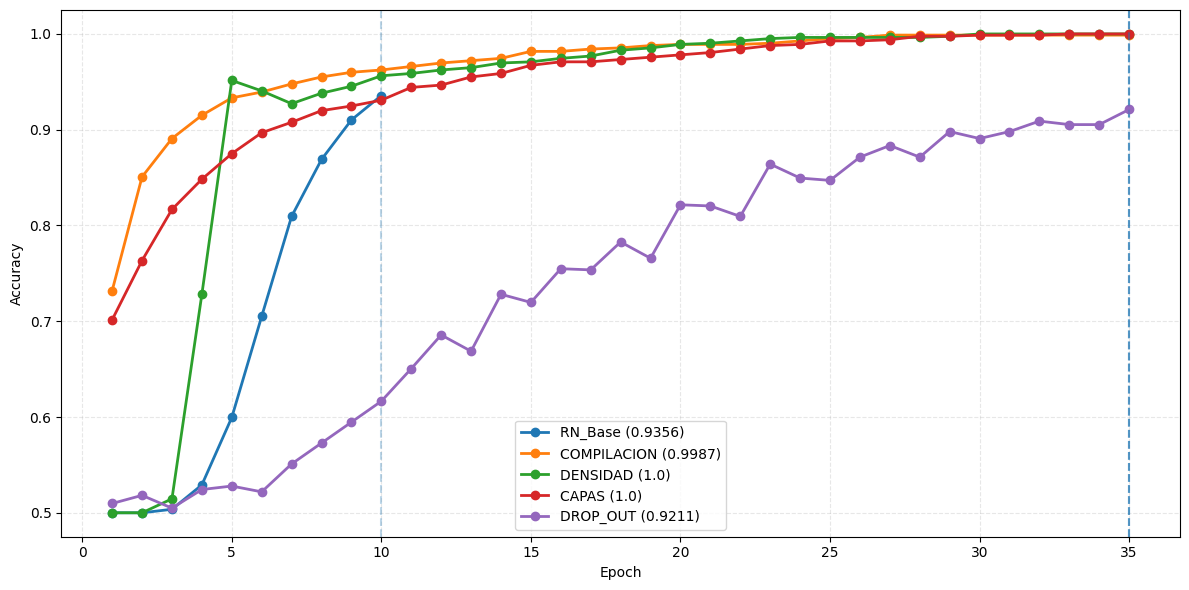

In [38]:
def truncar_decimales(x, decimales):
    factor = 10 ** decimales
    return int(x * factor) / factor

modelos_grafica = list(zip(resultados_metricas, resultados_modelos))

plt.figure(figsize=(12, 6))

n = len(modelos_grafica)
offset_y = np.linspace(-0.03, 0.03, n)
offset_x = np.linspace(0.10, 0.25, n)

for (registro, modelo), dy, dx in zip(modelos_grafica, offset_y, offset_x):
    nombre = registro["modelo"]
    acc_history = modelo.history.history["accuracy"]
    epocas = range(1, len(acc_history) + 1)

    acc_final = truncar_decimales(acc_history[-1], 4)

    plt.plot(epocas, acc_history, marker="o", linewidth=2, label=f"{nombre} ({acc_final})")

    epoca_final = len(acc_history)
    plt.axvline(x=epoca_final, linestyle="--", alpha=0.3)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
mejor_idx = max(
    range(len(resultados_metricas)),
    key=lambda i: resultados_metricas[i]["accuracy"]
)

mejor_registro = resultados_metricas[mejor_idx]
mejor_modelo = resultados_modelos[mejor_idx]

df_mejor = pd.DataFrame([mejor_registro])
display(df_mejor)

print("Nombre del mejor modelo:", mejor_registro["modelo"])


,modelo,accuracy,precision,recall,f1_score
0,COMPILACION,0.995146,1.0,0.990291,0.995122


Nombre del mejor modelo: COMPILACION


In [40]:
mejor_modelo.save("mejor_modelo.h5")

## <span id="sec6"></span> **6. Predicción con Nuevos Casos**


In [41]:
ITEM_COLUMNS = [
    'DETALLES_FINOS',
    'ENFOQUE_GLOBAL',
    'SEGUIR_CHARLAS',
    'CAMBIO_TAREAS',
    'ENTENDER_INTENCIONES',
    'NOTAR_INTERES',
    'IMAGINACION_SOCIAL',
    'INTERESES_INTENSOS',
    'LEER_FACIALES',
    'SOCIAL_AMISTAD'
]

def calcular_resultado(sample_dict):
    return int(sum(int(sample_dict[c]) for c in ITEM_COLUMNS))

binary_features = ITEM_COLUMNS + ['ICTERICIA', 'AUTISMO', 'USO_PREVIO']
numeric_features = ['EDAD', 'RESULTADO']
categorical_nominal_features = ['GENERO', 'ETNIA']

FEATURE_COLUMNS = binary_features + numeric_features + categorical_nominal_features

def transformar_sample(sample_dict, pipe):
    tmp = sample_dict.copy()
    tmp['RESULTADO'] = calcular_resultado(tmp)

    df_raw = pd.DataFrame([tmp])
    df_raw = df_raw[FEATURE_COLUMNS]
    X_new = pipe.transform(df_raw)

    return X_new

def predecir(sample_dict, pipe, modelo, threshold=0.7):
    X_new = transformar_sample(sample_dict, pipe)
    prob = float(modelo.predict(X_new).ravel()[0])
    decision = "yes" if prob >= threshold else "no"

    return {
        "probabilidad": prob,
        "porcentaje": prob * 100,
        "decision": decision
    }

In [42]:
#try:
#    print("Selecciona un archivo .h5 (opcional):")
#    uploaded = files.upload()
#
#    nombre = next(iter(uploaded.keys()))
#    mejor_modelo = load_model(nombre)
#    print("Modelo cargado desde archivo:", nombre)
#
#except Exception:
#    print("No se pudo cargar un modelo externo. Se utilizará el modelo en memoria.")

In [43]:
##   CASOS REALES

karen = {
    'DETALLES_FINOS': 0,
    'ENFOQUE_GLOBAL': 1,
    'SEGUIR_CHARLAS': 0,
    'CAMBIO_TAREAS': 1,
    'ENTENDER_INTENCIONES': 0,
    'NOTAR_INTERES': 1,
    'IMAGINACION_SOCIAL': 0,
    'INTERESES_INTENSOS': 0,
    'LEER_FACIALES': 0,
    'SOCIAL_AMISTAD': 0,
    'ICTERICIA': 0,
    'AUTISMO': 0,
    'USO_PREVIO': 0,
    'EDAD': 21,
    'GENERO': 'f',
    'ETNIA': 'Latino'
}


paul = {
    'DETALLES_FINOS': 1,
    'ENFOQUE_GLOBAL': 0,
    'SEGUIR_CHARLAS': 1,
    'CAMBIO_TAREAS': 0,
    'ENTENDER_INTENCIONES': 1,
    'NOTAR_INTERES': 1,
    'IMAGINACION_SOCIAL': 0,
    'INTERESES_INTENSOS': 1,
    'LEER_FACIALES': 1,
    'SOCIAL_AMISTAD': 0,
    'ICTERICIA': 0,
    'AUTISMO': 0,
    'USO_PREVIO': 0,
    'EDAD': 21,
    'GENERO': 'm',
    'ETNIA': 'Latino'
}

# CASO DONDE SE BUSCA UNA RESPUESTA DE YES
caso_alto = {
    'DETALLES_FINOS': 1,
    'ENFOQUE_GLOBAL': 1,
    'SEGUIR_CHARLAS': 1,
    'CAMBIO_TAREAS': 0,
    'ENTENDER_INTENCIONES': 1,
    'NOTAR_INTERES': 1,
    'IMAGINACION_SOCIAL': 0,
    'INTERESES_INTENSOS': 1,
    'LEER_FACIALES': 1,
    'SOCIAL_AMISTAD': 0,
    'ICTERICIA': 0,
    'AUTISMO': 0,
    'USO_PREVIO': 0,
    'EDAD': 26,
    'GENERO': 'f',
    'ETNIA': 'Latino'
}


In [44]:
print("RESULTADOS DE KAREN")
resultado_karen = predecir(karen, pipe, mejor_modelo)
print(resultado_karen)

print("RESULTADOS DE PAUL")
resultado_paul = predecir(paul, pipe, mejor_modelo)
print(resultado_paul)

print("RESULTADOS DE FORZADO")
resultado_caso_alto = predecir(caso_alto, pipe, mejor_modelo)
print(resultado_caso_alto)




RESULTADOS DE KAREN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
{'probabilidad': 0.003998850006610155, 'porcentaje': 0.3998850006610155, 'decision': 'no'}
RESULTADOS DE PAUL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'probabilidad': 0.3685643672943115, 'porcentaje': 36.85643672943115, 'decision': 'no'}
RESULTADOS DE FORZADO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
{'probabilidad': 0.947939932346344, 'porcentaje': 94.7939932346344, 'decision': 'yes'}


## <span id="sec7"></span> **Conclusiones**
El dataset original presentaba un desbalance severo (73% vs 27%), lo cual afectaba la detección de la clase minoritaria. Tras aplicar SMOTE, se obtuvo un conjunto perfectamente equilibrado (515–515), reduciendo el sesgo y permitiendo entrenar modelos que respondan de forma más justa a ambos tipos de casos.

El modelo optimizado por parámetros de **compilación** fue el más destacado, alcanzando un accuracy de test de 0.995146, precisión perfecta de 1.0 y un f1 de 0.995122. Su curva de entrenamiento fue la más estable y rápida, llegando a 1.0 de accuracy antes de la mitad de las epoch.

En test, **COMPILACIÓN** y **DENSIDAD** mantienen el mejor desempeño, ambos con accuracy de 0.9951 y F1-score de 0.9951, confirmando que la estabilidad mostrada en entrenamiento se sostiene en datos nuevos.

Todos los modelos lograron converger, pero con diferencias claras en
estabilidad y rendimiento final. El modelo base se ubicó como referencia con 0.9466 de accuracy en test, mientras que las versiones optimizadas elevaron el rendimiento a niveles superiores al 0.97. Los parámetros como activaciones, densidad y dropout demostraron impacto real en el aprendizaje, aunque no todas las técnicas ofrecieron mejoras frente a configuraciones más simples.

Los casos reales evidencian la capacidad del modelo para discriminar perfiles distintos: Karen obtuvo una probabilidad del 0.19% (decisión “no”), Paul obtuvo 30.74% también “no”, mientras que el caso alto alcanzó 94.36% (“yes”). Esto confirma que el modelo generaliza adecuadamente sobre patrones no vistos y responde de forma coherente con la estructura de los datos y las métricas alcanzadas durante el entrenamiento.


